In [8]:
%%capture
!pip install torch-geometric

In [80]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [10]:
CMAP = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

In [63]:
X_train = pd.read_json('arc-agi_training_challenges.json', orient='index')
y_train = pd.read_json('arc-agi_training_solutions.json', orient='index')

In [12]:
''' This function will take the rows of the above X_train, and split
the data into different inputs and outputs of the training example, before
providing the test example'''

def split_data(row):
  inputs = []
  outputs = []
  for element in row:
    inputs.append(element['input'])
    outputs.append(element['output'])
  return pd.Series({'input': inputs, 'output': outputs})


In [64]:
## Seperate input and output into seperate columns
X_train = pd.concat([X_train, X_train['train'].apply(split_data)], axis=1)

In [65]:
X_train = X_train[["input", "output", "test"]]

In [66]:
'''This function will split each input and output for a corresponding
reasoning task, it will also refine the test column'''

def format_data(data):
  new_data = data.explode(['input', 'output'])
  new_data['test'] = new_data['test'].apply(lambda x: x[0]['input'])
  return new_data

In [67]:
X_train = format_data(X_train)

In [68]:
X_train

,input,output,test
007bbfb7,"[[0, 7, 7], [7, 7, 7], [0, 7, 7]]","[[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, ...","[[7, 0, 7], [7, 0, 7], [7, 7, 0]]"
007bbfb7,"[[4, 0, 4], [0, 0, 0], [0, 4, 0]]","[[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, ...","[[7, 0, 7], [7, 0, 7], [7, 7, 0]]"
007bbfb7,"[[0, 0, 0], [0, 0, 2], [2, 0, 2]]","[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, ...","[[7, 0, 7], [7, 0, 7], [7, 7, 0]]"
007bbfb7,"[[6, 6, 0], [6, 0, 0], [0, 6, 6]]","[[6, 6, 0, 6, 6, 0, 0, 0, 0], [6, 0, 0, 6, 0, ...","[[7, 0, 7], [7, 0, 7], [7, 7, 0]]"
007bbfb7,"[[2, 2, 2], [0, 0, 0], [0, 2, 2]]","[[2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 0, 0, 0, 0, ...","[[7, 0, 7], [7, 0, 7], [7, 7, 0]]"
...,...,...,...
ff28f65a,"[[0, 0, 0, 0, 2, 2, 0], [0, 2, 2, 0, 2, 2, 0],...","[[1, 0, 1], [0, 1, 0], [1, 0, 1]]","[[0, 0, 0, 2, 2, 0], [2, 2, 0, 2, 2, 0], [2, 2..."
ff28f65a,"[[0, 0, 2, 2, 0, 2, 2], [0, 0, 2, 2, 0, 2, 2],...","[[1, 0, 1], [0, 1, 0], [1, 0, 0]]","[[0, 0, 0, 2, 2, 0], [2, 2, 0, 2, 2, 0], [2, 2..."
ff805c23,"[[0, 3, 3, 3, 3, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2,...","[[0, 3, 3, 3, 3], [0, 3, 3, 3, 3], [3, 0, 0, 3...","[[4, 4, 4, 0, 4, 0, 0, 3, 3, 3, 0, 0, 0, 0, 3,..."
ff805c23,"[[0, 3, 3, 3, 0, 3, 0, 8, 8, 0, 8, 8, 8, 8, 0,...","[[6, 6, 6, 6, 6], [6, 6, 6, 6, 6], [6, 6, 0, 6...","[[4, 4, 4, 0, 4, 0, 0, 3, 3, 3, 0, 0, 0, 0, 3,..."


In [19]:
def pad_array(row):

  target_shape = (30, 30)
  array = np.array(row)
  padded_array = np.pad(array,
                        pad_width=((0, target_shape[0] - array.shape[0]),
                                   (0, target_shape[1] - array.shape[1])),
                        mode='constant',
                        constant_values=0)
  return padded_array

In [69]:
## 30x30 padding of array applied to each input/target/test
X_train['input'] = X_train['input'].apply(pad_array)
X_train['output'] = X_train['output'].apply(pad_array)
X_train['test'] = X_train['test'].apply(pad_array)

In [83]:
def create_data_object(row):
  # Define your 2D array and the corresponding colors array
  input = np.array(row['input'])
  array = np.arange(input.shape[0] * input.shape[1]).reshape(input.shape[0],
                                                               input.shape[1])
  target = np.array(row['output']).flatten().reshape(-1, 1)

  # Function to create edges with diagonal connections
  def create_edges_2d_with_diagonals(array):
      rows = len(array)
      cols = len(array[0])
      edges = []

      for i in range(rows):
          for j in range(cols):
              for di in [-1, 0, 1]:
                  for dj in [-1, 0, 1]:
                      if di == 0 and dj == 0:
                          continue
                      ni, nj = i + di, j + dj
                      if 0 <= ni < rows and 0 <= nj < cols:
                          edges.append((i * cols + j, ni * cols + nj))

      return edges

  # Create edges
  edges = create_edges_2d_with_diagonals(array)

  # Flatten the colors array to create node features
  node_features = input.flatten().reshape(-1, 1)

  # Convert to PyTorch tensors
  edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
  x = torch.tensor(node_features, dtype=torch.float)
  y = torch.tensor(target, dtype=torch.float)

  # Create the PyTorch Geometric Data object
  data = Data(x=x, edge_index=edge_index, y=y)

  return data

In [84]:
data_list = [create_data_object(row) for idx, row in X_train.iterrows()]

In [85]:
# Create a DataLoader
batch_size = 100
loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [22]:
X_train.head()

,input,output,test
007bbfb7,"[(x, [tensor([0.]), tensor([7.]), tensor([7.])...","[(x, [tensor([0.]), tensor([0.]), tensor([0.])...","[(x, [tensor([7.]), tensor([0.]), tensor([7.])..."
007bbfb7,"[(x, [tensor([4.]), tensor([0.]), tensor([4.])...","[(x, [tensor([4.]), tensor([0.]), tensor([4.])...","[(x, [tensor([7.]), tensor([0.]), tensor([7.])..."
007bbfb7,"[(x, [tensor([0.]), tensor([0.]), tensor([0.])...","[(x, [tensor([0.]), tensor([0.]), tensor([0.])...","[(x, [tensor([7.]), tensor([0.]), tensor([7.])..."
007bbfb7,"[(x, [tensor([6.]), tensor([6.]), tensor([0.])...","[(x, [tensor([6.]), tensor([6.]), tensor([0.])...","[(x, [tensor([7.]), tensor([0.]), tensor([7.])..."
007bbfb7,"[(x, [tensor([2.]), tensor([2.]), tensor([2.])...","[(x, [tensor([2.]), tensor([2.]), tensor([2.])...","[(x, [tensor([7.]), tensor([0.]), tensor([7.])..."


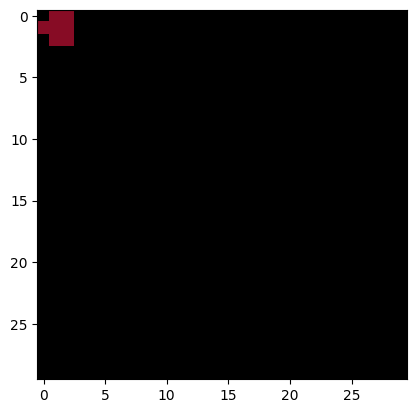

In [28]:
## visualizing data to see padded arrays
plt.imshow(X_train.iloc[0]['input'].x.numpy().reshape(30,30), cmap=CMAP)
plt.show()

In [51]:
## GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        # Define two graph convolution layers
        self.conv1 = GCNConv(in_channels=in_channels, out_channels=hidden_channels)
        self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.conv3 = GCNConv(in_channels=hidden_channels, out_channels=out_channels)

    def forward(self, data):
        # Get node features and edge index
        x, edge_index = data.x, data.edge_index

        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x= F.relu(x)

        # Third GCN layer
        x = self.conv3(x, edge_index)

        return x


In [86]:
# Create the model and print it
model = GCN(in_channels=1, hidden_channels=64, out_channels=1)
print(model)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 1)
)


In [87]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(loader):.4f}')

# Perform a forward pass after training
model.eval()
with torch.no_grad():
    for data in loader:
        out = model(data)
        print(out)

Epoch [1/100], Loss: 0.8131
Epoch [2/100], Loss: 0.8305
Epoch [3/100], Loss: 0.7985
Epoch [4/100], Loss: 0.8122
Epoch [5/100], Loss: 0.7965
Epoch [6/100], Loss: 0.7933
Epoch [7/100], Loss: 0.7958
Epoch [8/100], Loss: 0.7891
Epoch [9/100], Loss: 0.7968
Epoch [10/100], Loss: 0.8026
Epoch [11/100], Loss: 0.7977
Epoch [12/100], Loss: 0.7878
Epoch [13/100], Loss: 0.8081
Epoch [14/100], Loss: 0.7978
Epoch [15/100], Loss: 0.7918
Epoch [16/100], Loss: 0.7965
Epoch [17/100], Loss: 0.7941
Epoch [18/100], Loss: 0.7988
Epoch [19/100], Loss: 0.7957
Epoch [20/100], Loss: 0.7963
Epoch [21/100], Loss: 0.7978
Epoch [22/100], Loss: 0.7934
Epoch [23/100], Loss: 0.7909
Epoch [24/100], Loss: 0.7962
Epoch [25/100], Loss: 0.7865
Epoch [26/100], Loss: 0.7945
Epoch [27/100], Loss: 0.7970
Epoch [28/100], Loss: 0.7895
Epoch [29/100], Loss: 0.7907
Epoch [30/100], Loss: 0.8005
Epoch [31/100], Loss: 0.7866
Epoch [32/100], Loss: 0.7923
Epoch [33/100], Loss: 0.7890
Epoch [34/100], Loss: 0.8012
Epoch [35/100], Loss: 0

KeyboardInterrupt: 

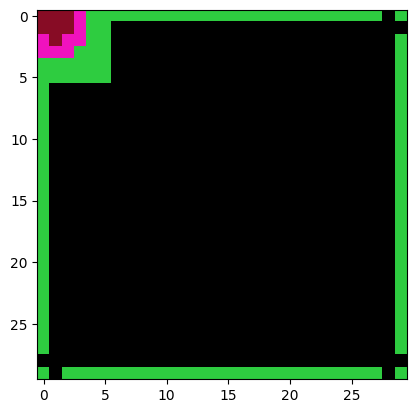

In [92]:
instance = create_data_object(X_train.iloc[0])
model.eval()
with torch.no_grad():
    out = model(instance).reshape(30,30)//1
    plt.imshow(out, cmap=CMAP)
    plt.show()